In [1]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import geopandas as gpd
from shapely.geometry import Point
import shapely
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.tsa.stattools as sm

In [2]:
data = pd.read_excel('/Users/VarshiniSelvadurai/Documents/Internship/Crime_Edited.xlsx', sheet_name = 'May')
#data = pd.read_excel('C:\\Users\\vns8\\Documents\\Crime_Edited.xlsx', sheet_name = 'May')
data = data.loc[data["Crime Name1"] != "Not a Crime"]
data = data.drop(columns = ["Police District Number","Address Number","Victims","CR Number","NIBRS Code","Beat","PRA","State","Incident ID","Offence Code","Sector","Police District Name","Crime Name2","Crime Name3","Agency","Place","End Date/Time","Dispatch Date/Time","Block_Address"])
ugh = list(map(str, data["Start Time"]))
for i in range (0, len(ugh)):
    ugh[i] = ugh[i][:2]
data["Start Time"] = ugh
ugh = (list(map(str,data['Start Date'])))
ughh = []
for i in range(0,len(ugh)):
    ugh[i] = ugh[i][5:]
    ugh[i] = ugh[i][:5]
data['Start Date'] = ugh

In [3]:
z_20902 = data.loc[data["Zip Code"] == 20902]
z_20906 = data.loc[data["Zip Code"] == 20906]
z_20904 = data.loc[data["Zip Code"] == 20904]
z_20910 = data.loc[data["Zip Code"] == 20910]
z_20874 = data.loc[data["Zip Code"] == 20874]

# CASE 1

In [4]:
def case1(data, title):
    start_date = list(map(str, data['Start Date'].value_counts().keys().tolist()))
    start_date.sort()
    start_time = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    start_time.sort()
    ugh = [0 for i in range(0,len(start_date)*len(start_time))]
    ughh = [0 for i in range(0,len(start_date)*len(start_time))]
    for index,row in data.iterrows():
        a = start_date.index(row["Start Date"])
        b = int(row["Start Time"])
        ugh[24*a + b] += 1
        ughh[24*a + b] = row["Start Date"] + row["Start Time"]
    march = pd.DataFrame({"Crime Count": ugh, "Date and Time":ughh} )
    march.plot(kind = "line", y = "Crime Count", figsize = (20,10), title = ("May 7-20" +str(title)), xticks = [i for i in range (0,336,24)], grid = True)
    return march

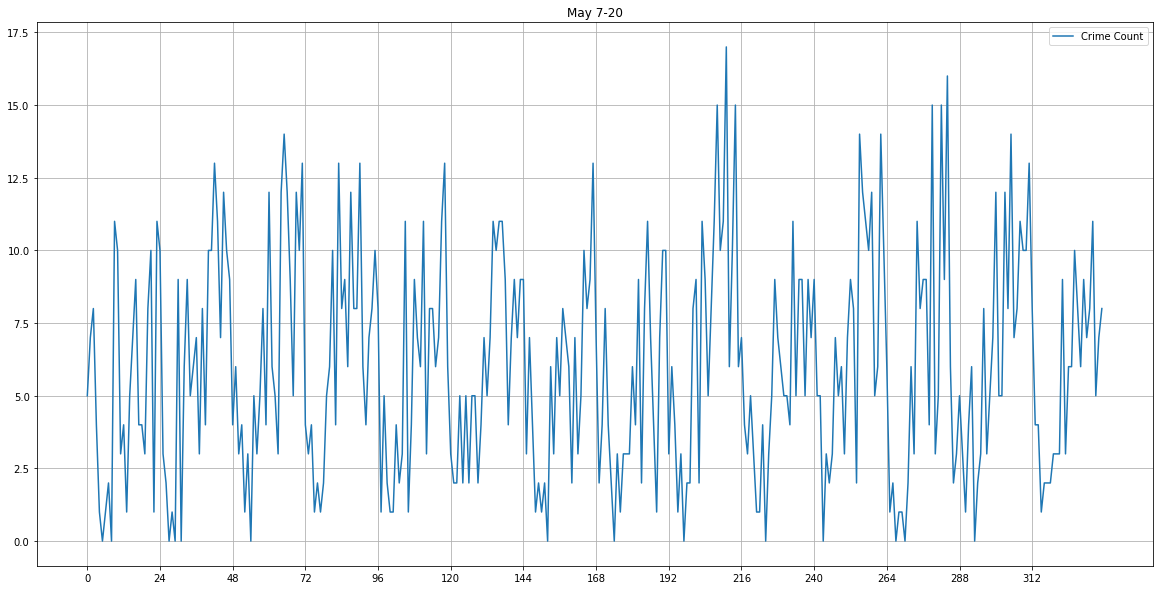

In [5]:
hour_data = case1(data,"")

### ARIMA

##### Not super sure what the results mean...

                             ARIMA Model Results                              
Dep. Variable:          D.Crime Count   No. Observations:                  335
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -911.351
Method:                       css-mle   S.D. of innovations              3.674
Date:                Wed, 25 Jul 2018   AIC                           1828.702
Time:                        15:17:06   BIC                           1840.145
Sample:                             1   HQIC                          1833.264
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0063      0.140      0.045      0.964      -0.269       0.282
ar.L1.D.Crime Count    -0.4306      0.049     -8.753      0.000      -0.527      -0.334
                

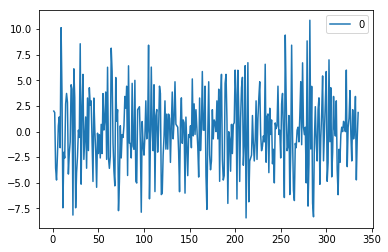

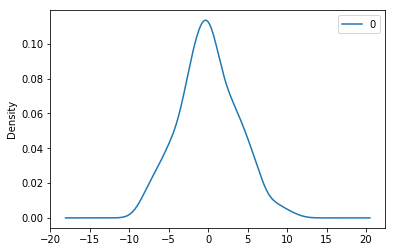

                0
count  335.000000
mean     0.002563
std      3.679520
min     -8.425184
25%     -2.300865
50%     -0.162128
75%      2.352291
max     10.852291


In [6]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(hour_data["Crime Count"], order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

### Power Spectrum - Periodogram

##### IT WORKS: at least im assuming it does cause the period is 24 hours... 

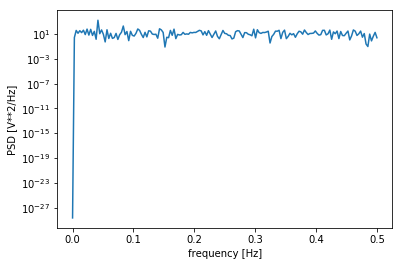

Max Frequency: 0.041666666666666664 Hz
Period = 1/ Frequency: 24.0 hours


In [20]:
from scipy import signal
f, Pxx_den = signal.periodogram(hour_data["Crime Count"])
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()
max_frequency = (f[list(Pxx_den).index(max(Pxx_den))])
print("Max Frequency:", max_frequency, "Hz")
print("Period = 1/ Frequency: " + str(1/max_frequency) + " hours")

### Seasonal Decomposition

##### additive vs. multiplicative: neither works

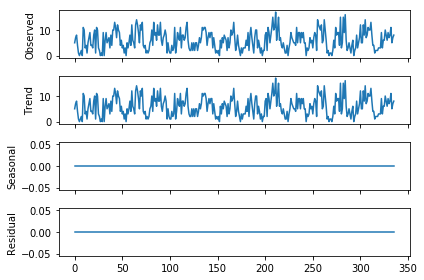

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(hour_data["Crime Count"], model='additive', freq=1)
result.plot()
plt.show()

result = seasonal_decompose(hour_data["Crime Count"], model='multiplicative', freq=1)
result.plot()
plt.show()

### Autocorrelation Plot

##### shows that the best lag against itself is 1 (obvious) --> not sure how it relates to seasonality

/Users/VarshiniSelvadurai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


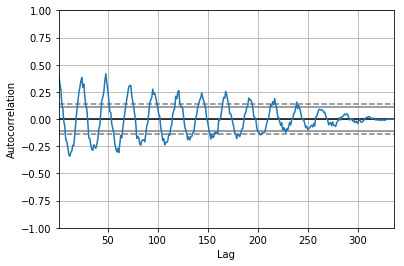

In [9]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(hour_data["Crime Count"])
#shows that optimal lag is 0

### Seasonal Subseries Plot

##### Can show an overall trend (usefull to see increase in weekends) but not sure how to do this in python (i don't think there is a function for this)

### Boxplot

##### If you look at the medians in the boxplot you can see a general trend...this works the same and the seasonal subseries but figuring out how to do that might be more effective

{'whiskers': [<matplotlib.lines.Line2D at 0x1c14b7ef60>,
 'caps': [<matplotlib.lines.Line2D at 0x1c1d08d0b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c14b7eb38>,
 'medians': [<matplotlib.lines.Line2D at 0x1c1d7ac160>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c1d7aca20>,
 'means': []}

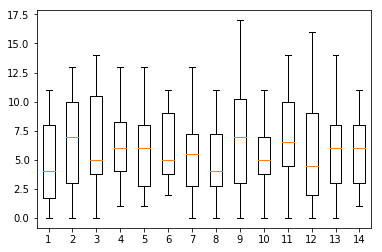

In [10]:
fig, ax = plt.subplots()
h = [list(hour_data["Crime Count"])[0:24],
    list(hour_data["Crime Count"])[24:48],
    list(hour_data["Crime Count"])[48:72],
    list(hour_data["Crime Count"])[72:96],
    list(hour_data["Crime Count"])[96:120],
    list(hour_data["Crime Count"])[120:144],
    list(hour_data["Crime Count"])[144:168],
    list(hour_data["Crime Count"])[168:192],
    list(hour_data["Crime Count"])[192:216],
    list(hour_data["Crime Count"])[216:240],
    list(hour_data["Crime Count"])[240:264],
    list(hour_data["Crime Count"])[264:288],
    list(hour_data["Crime Count"])[288:2312],
    list(hour_data["Crime Count"])[312:336]]
ax.boxplot(h)

# CASE 2 

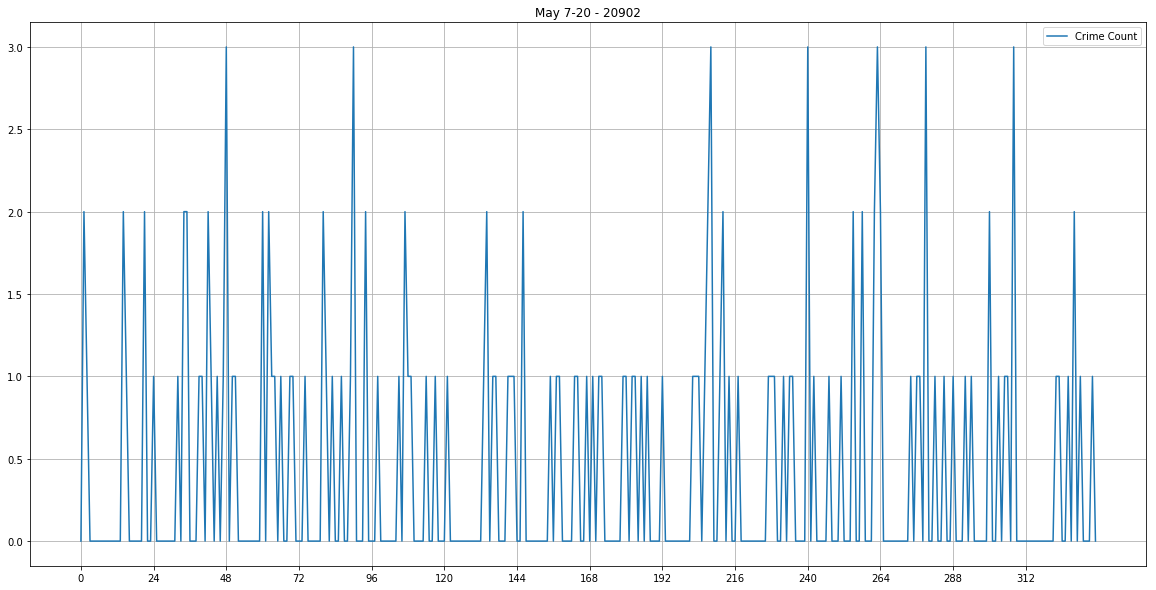

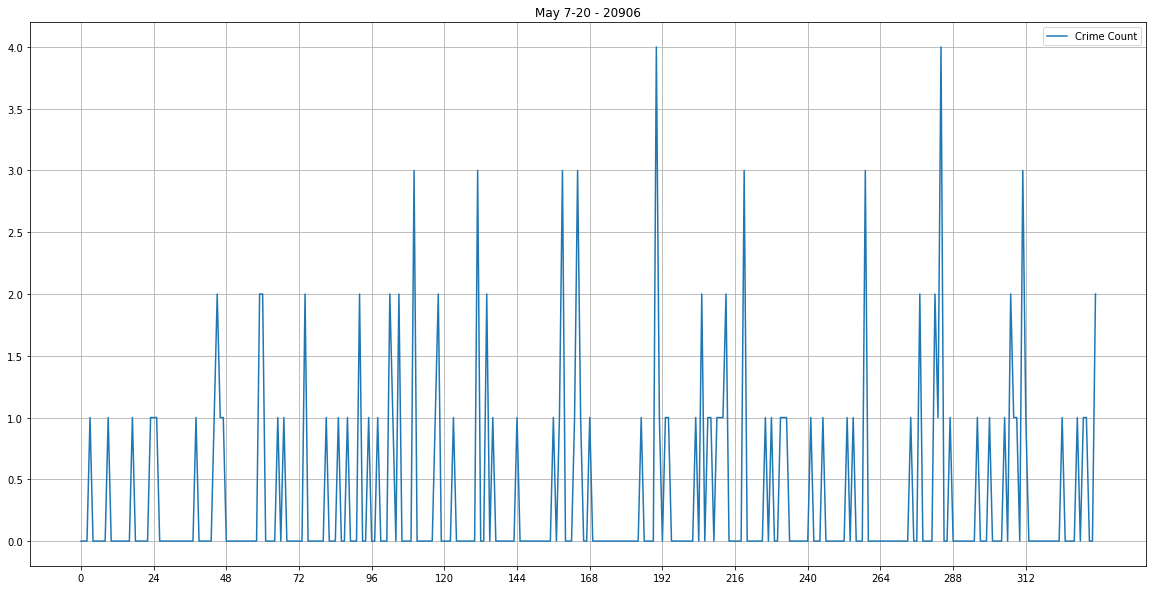

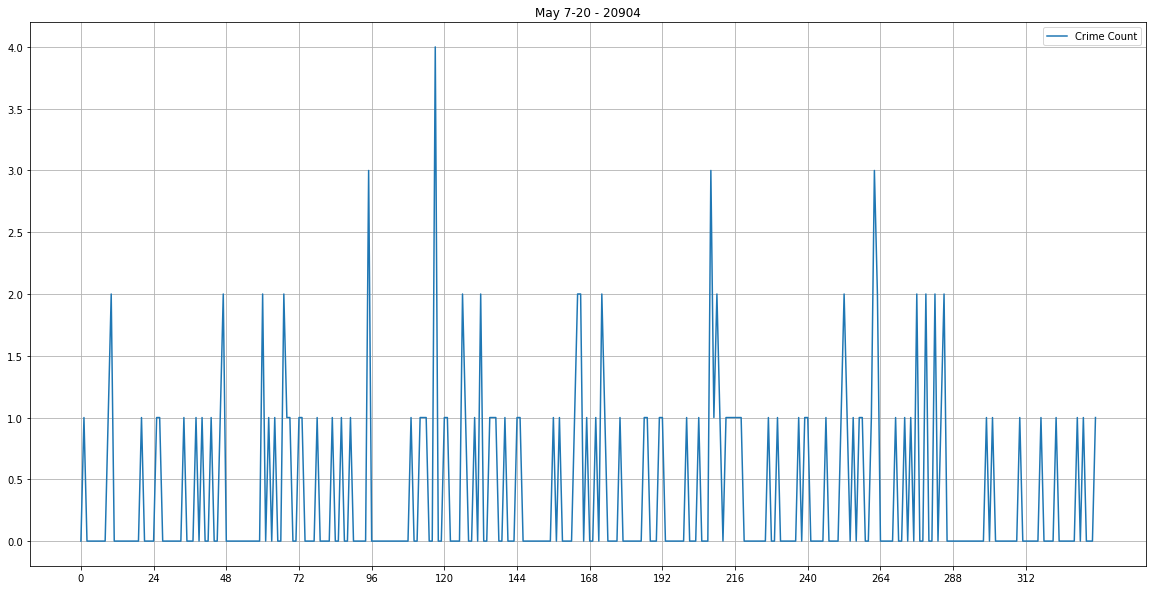

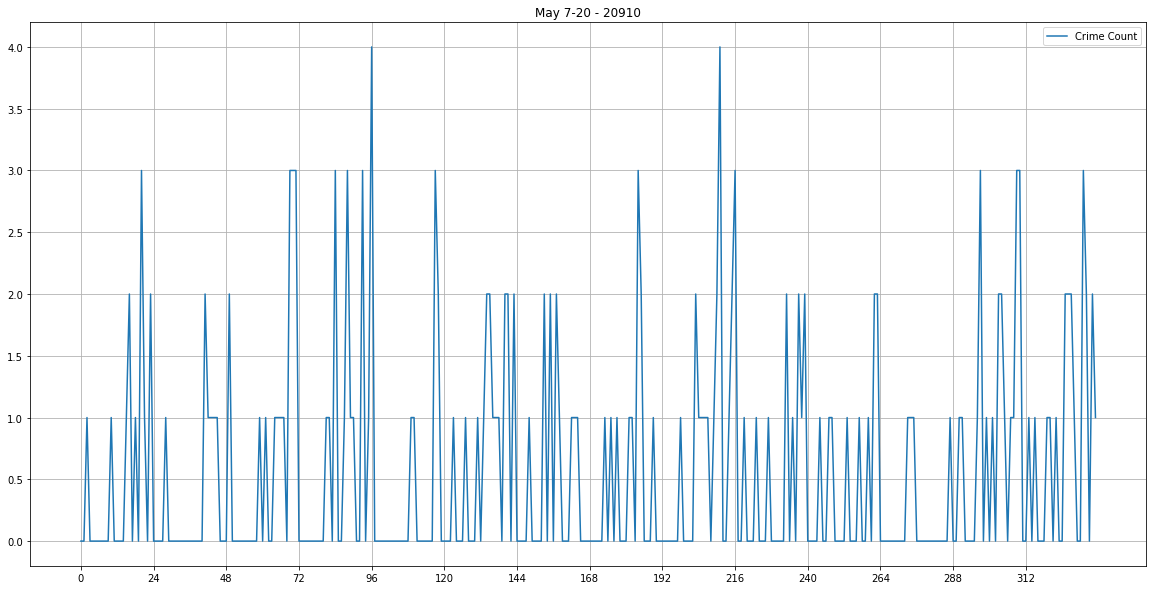

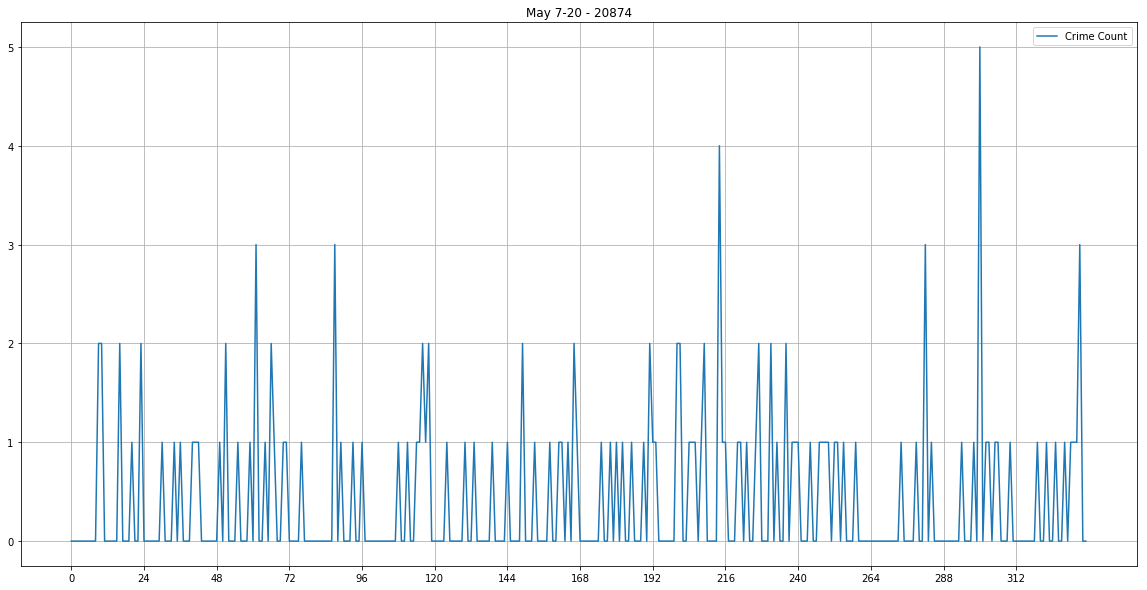

In [11]:
hour_20902 = case1(z_20902, " - 20902")
hour_20906 = case1(z_20906, " - 20906")
hour_20904 = case1(z_20904, " - 20904")
hour_20910 = case1(z_20910, " - 20910")
hour_20874 = case1(z_20874, " - 20874")

In [12]:
x = np.column_stack((list(hour_20902["Crime Count"]),list(hour_20902["Crime Count"])))
sm.grangercausalitytests(x = x,maxlag = 23)
x = np.column_stack((list(hour_20902["Crime Count"]),list(hour_20904["Crime Count"])))
sm.grangercausalitytests(x = x,maxlag = 23)
x = np.column_stack((list(hour_20902["Crime Count"]),list(hour_20906["Crime Count"])))
sm.grangercausalitytests(x = x,maxlag = 23)
x = np.column_stack((list(hour_20902["Crime Count"]),list(hour_20910["Crime Count"])))
sm.grangercausalitytests(x = x,maxlag = 23)
x = np.column_stack((list(hour_20902["Crime Count"]),list(hour_20874["Crime Count"])))
sm.grangercausalitytests(x = x,maxlag = 23)

zipcodes = ["hour_20902","hour_20904","hour_20906","hour_20910","hour_20874"]
for z in zipcodes:
    for z2 in zipcodes:
        x = np.column_stack((list(z["Crime Count"]),list(z2["Crime Count"])))
        print(z + z2)
        sm.grangercausalitytests(x = x,maxlag = 23)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=333, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=0.2166  , p=0.6419  , df_denom=333, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=331, df_num=2
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=0.1948  , p=0.8231  , df_denom=331, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=329, df_num=3
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=0.2262  , p=0.8781  , df_denom=329, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0000  , p=1.0000  

ssr based F test:         F=0.7772  , p=0.6843  , df_denom=296, df_num=13
ssr based chi2 test:   chi2=11.0246 , p=0.6088  , df=13
likelihood ratio test: chi2=10.8406 , p=0.6242  , df=13
parameter F test:         F=0.7772  , p=0.6843  , df_denom=296, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=0.7145  , p=0.7596  , df_denom=293, df_num=14
ssr based chi2 test:   chi2=10.9925 , p=0.6866  , df=14
likelihood ratio test: chi2=10.8090 , p=0.7010  , df=14
parameter F test:         F=0.7145  , p=0.7596  , df_denom=293, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=0.7803  , p=0.6994  , df_denom=290, df_num=15
ssr based chi2 test:   chi2=12.9551 , p=0.6058  , df=15
likelihood ratio test: chi2=12.7005 , p=0.6254  , df=15
parameter F test:         F=0.7803  , p=0.6994  , df_denom=290, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=0.8126  , p=0.6711  , df_denom=287, df_num=16
ssr b

parameter F test:         F=1.9019  , p=0.0259  , df_denom=293, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=2.2305  , p=0.0057  , df_denom=290, df_num=15
ssr based chi2 test:   chi2=37.0337 , p=0.0013  , df=15
likelihood ratio test: chi2=35.0487 , p=0.0024  , df=15
parameter F test:         F=2.2305  , p=0.0057  , df_denom=290, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=2.0757  , p=0.0095  , df_denom=287, df_num=16
ssr based chi2 test:   chi2=37.0304 , p=0.0021  , df=16
likelihood ratio test: chi2=35.0400 , p=0.0039  , df=16
parameter F test:         F=2.0757  , p=0.0095  , df_denom=287, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=1.8243  , p=0.0249  , df_denom=284, df_num=17
ssr based chi2 test:   chi2=34.8354 , p=0.0065  , df=17
likelihood ratio test: chi2=33.0614 , p=0.0111  , df=17
parameter F test:         F=1.8243  , p=0.0249  , df_denom=284, df_num=17

Gran

likelihood ratio test: chi2=34.1527 , p=0.0630  , df=23
parameter F test:         F=1.3333  , p=0.1451  , df_denom=266, df_num=23


TypeError: string indices must be integers